##### Copyright 2020 The Cirq Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# QAOA: Max-Cut

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/qaoa"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/qaoa.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/qaoa.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/qaoa.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In this tutorial, we implement the quantum approximate optimization algorithm (QAOA) for determining the Max-Cut of the Bristlecone processor's hardware graph (with random edge weights). To do so, we will:

1. Define a random set of weights over the hardware graph.
2. Construct a QAOA circuit using Cirq.
3. Calculate the expected value of the QAOA cost function.
4. Create an outer loop optimization to minimize the cost function.
5. Compare cuts found from QAOA with random cuts.

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

## 1. Defining a random set of weights over the hardware graph
In order to make the problem easily embeddable on a quantum device, we will look at the problem of Max-Cut on the same graph that the device's qubit connectivity defines, but with random valued edge weights.

In [3]:
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
working_device = cirq.google.Bristlecone
print(working_device)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

Since a circuit covering the entire Bristlecone device cannot be easily simulated, a small subset of the device graph will be used instead.

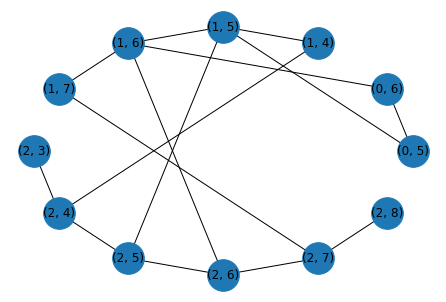

In [4]:
import networkx as nx

# Set the seed to determine the problem instance.
np.random.seed(seed=11)

# Identify working qubits from the device.
device_qubits = working_device.qubits
working_qubits = sorted(device_qubits)[:12]

# Populate a networkx graph with working_qubits as nodes.
working_graph = nx.Graph()
for qubit in working_qubits:
  working_graph.add_node(qubit)

# Pair up all neighbors with random weights in working_graph.
for qubit in working_qubits:
  for neighbor in working_device.neighbors_of(qubit):
    if neighbor in working_graph:
      # Generate a randomly weighted edge between them. Here the weighting
      # is a random 2 decimal floating point between 0 and 5.
      working_graph.add_edge(
          qubit, neighbor, weight=np.random.randint(0, 500) / 100
      )

nx.draw_circular(working_graph, node_size=1000, with_labels=True)
plt.show()

## 2. Construct the QAOA circuit
Now that we have created a Max-Cut problem graph, it's time to generate the QAOA circuit following [Farhi et al.](https://arxiv.org/abs/1411.4028). For simplicity $p = 1$ is chosen.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


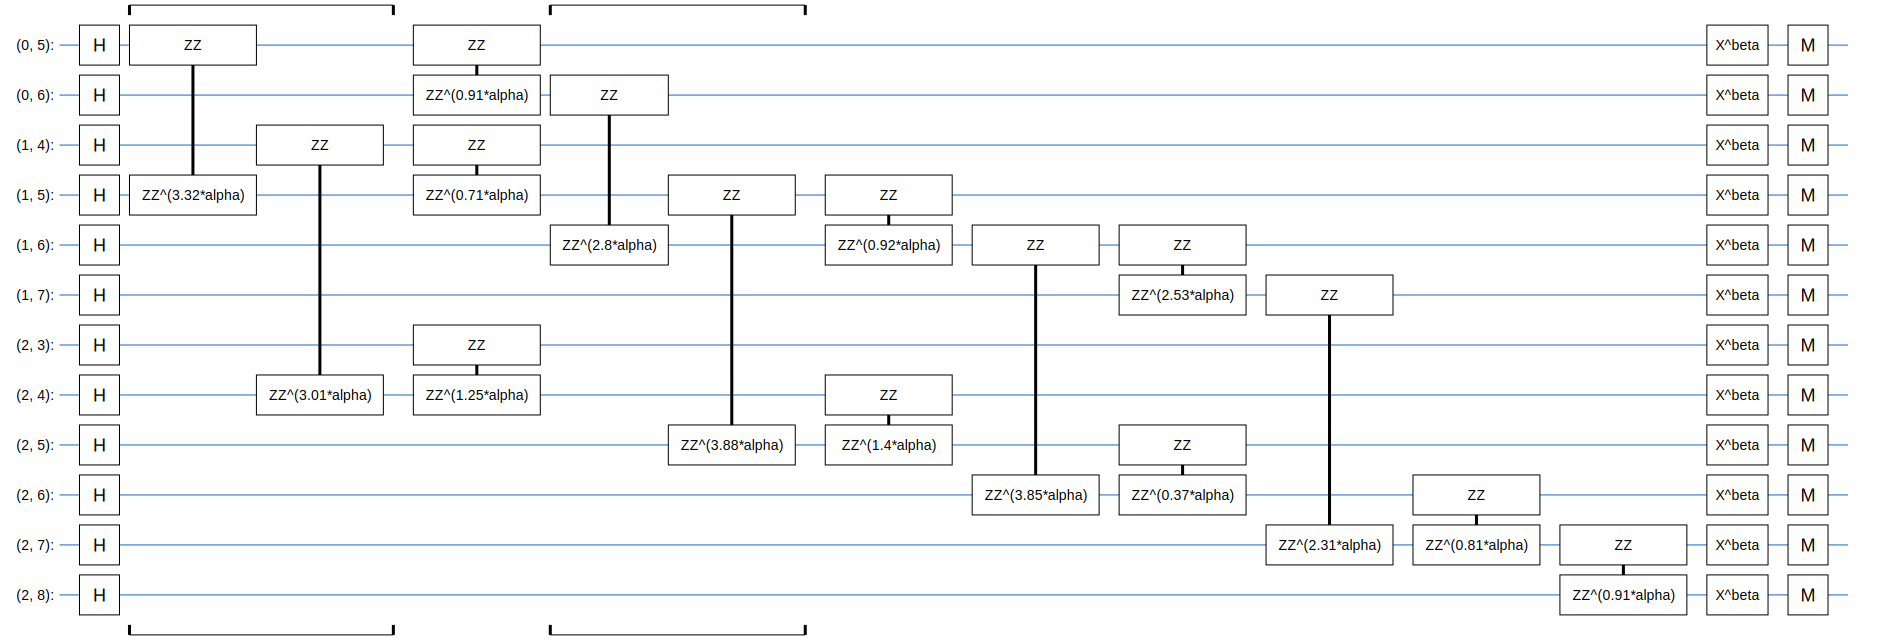

In [5]:
from cirq.contrib.svg import SVGCircuit

# Symbols for the rotation angles in the QAOA circuit.
alpha = sympy.Symbol('alpha')
beta = sympy.Symbol('beta')

qaoa_circuit = cirq.Circuit(
    # Prepare uniform superposition on working_qubits == working_graph.nodes
    cirq.H.on_each(working_graph.nodes()),

    # Do ZZ operations between neighbors u, v in the graph. Here, u is a qubit,
    # v is its neighboring qubit, and w is the weight between these qubits.
    (cirq.ZZ(u, v) ** (alpha * w['weight']) for (u, v, w) in working_graph.edges(data=True)),

    # Apply X operations along all nodes of the graph. Again working_graph's
    # nodes are the working_qubits. Note here we use a moment
    # which will force all of the gates into the same line.
    cirq.Moment(cirq.X(qubit) ** beta for qubit in working_graph.nodes()),
    
    # All relevant things can be computed in the computational basis.
    (cirq.measure(qubit) for qubit in working_graph.nodes()),
)
SVGCircuit(qaoa_circuit)

## 3. Calculating the expected value of the QAOA cost Hamiltonian
Now that we have created a parameterized QAOA circuit, we need a way to calculate expectation values of the cost Hamiltonian. For Max-Cut, the cost Hamiltonian is

$$
    H_C = \frac{1}{2} \sum_{\langle i, j\rangle} w_{ij} (1 - Z_i Z_j )
$$

where $\langle i, j \rangle$ denotes neighboring qubits, $w_{ij}$ is the weight of edge $ij$, and $Z$ is the usual Pauli-$Z$ matrix. The expectation value of this cost Hamiltonian is $\langle \alpha, \beta | H_C | \alpha, \beta \rangle$ where $|\alpha, \beta\rangle$ is the quantum state prepared by our `qaoa_circuit`. This is the cost function we need to estimate.

> Pauli-$Z$ has eigenvalues $\pm 1$. If qubits $i$ and $j$ are in the same eigenspace, then $\langle Z_i Z_j \rangle = 1$ and so $\frac{1}{2} w_{ij} \langle 1 - Z_i Z_j \rangle = 0$. In the Max-Cut language, this means that edge $ij$ does not contribute to the cost. If qubits $i$ and $j$ are in the opposite eigenspace, then $\langle Z_i Z_j \rangle = -1$ and so $\frac{1}{2} w_{ij} \langle 1 - Z_i Z_j \rangle = w_{ij}$. In the Max-Cut language, this means that edge $ij$ contributes its weight $w_{ij}$ to the cost. 

To estimate the cost function, we need to estimate the (weighted) sum of all $ZZ$ pairs in the graph. Since these terms are diagonal in the same basis (namely, the computational basis), they can measured simultaneously. Given a set of measurements (samples), the function below estimates the cost function.

> *Note*: We say "estimate the cost" instead of "compute the cost" since we are sampling from the circuit. This is how the cost would be evaluated when running QAOA on a real quantum processor.

In [6]:
def estimate_cost(graph, samples):
    """Estimate the cost function of the QAOA on the given graph using the
    provided computational basis bitstrings."""
    cost_value = 0.0

    # Loop over edge pairs and compute contribution.
    for u, v, w in graph.edges(data=True):
      u_samples = samples[str(u)]
      v_samples = samples[str(v)]

      # Determine if it was a +1 or -1 eigenvalue.
      u_signs = (-1)**u_samples
      v_signs = (-1)**v_samples
      term_signs = u_signs * v_signs

      # Add scaled term to total cost.
      term_val = np.mean(term_signs) * w['weight']
      cost_value += term_val

    return -cost_value

Now we can sample from the `qaoa_circuit` and use `estimate_expectation` to calculate the expectation value of the cost function for the circuit. Below, we use arbitrary values for $\alpha$ and $\beta$.

In [7]:
alpha_value = np.pi / 4
beta_value = np.pi / 2
sim = cirq.Simulator()

sample_results = sim.sample(
    qaoa_circuit, 
    params={alpha: alpha_value, beta: beta_value}, 
    repetitions=20_000
)
print(f'Alpha = {round(alpha_value, 3)} Beta = {round(beta_value, 3)}')
print(f'Estimated cost: {estimate_cost(working_graph, sample_results)}')

Alpha = 0.785 Beta = 1.571
Estimated cost: -0.22279300000000013


## 4. Outer loop optimization
Now that we can compute the cost function, we want to find the optimal cost. There are lots of different techniques to choose optimal parameters for the `qaoa_circuit`. Since there are only two parameters here ($\alpha$ and $\beta$), we can keep things simple and sweep over incremental pairings using `np.linspace` and track the minimum value found along the way.

In [8]:
# Set the grid size = number of points in the interval [0, 2π).
grid_size = 5

exp_values = np.empty((grid_size, grid_size))
par_values = np.empty((grid_size, grid_size, 2))

for i, alpha_value in enumerate(np.linspace(0, 2 * np.pi, grid_size)):
  for j, beta_value in enumerate(np.linspace(0, 2 * np.pi, grid_size)):
    samples = sim.sample(
        qaoa_circuit,
        params={alpha: alpha_value, beta: beta_value},
        repetitions=20000
    )
    exp_values[i][j] = estimate_cost(working_graph, samples)
    par_values[i][j] = alpha_value, beta_value

We can now visualize the cost as a function of $\alpha$ and $\beta$.

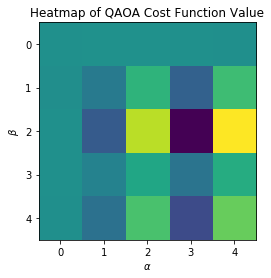

In [9]:
plt.title('Heatmap of QAOA Cost Function Value')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.imshow(exp_values);

This heatmap is coarse because we selected a small `grid_size`. To see more detail in the heatmap, one can increase the `grid_size`. 

## 5. Compare cuts

We now compare the optimal cut found by QAOA to a randomly selected cut. The helper function draws the `working_graph` and colors nodes in different sets different colors. Additionally, we print out the cost function for the given cut.

In [10]:
def output_cut(S_partition):
  """Plot and output the graph cut information."""

  # Generate the colors.
  coloring = []
  for node in working_graph:
    if node in S_partition:
      coloring.append('blue')
    else:
      coloring.append('red')

  # Get the weights
  edges = working_graph.edges(data=True)
  weights = [w['weight'] for (u,v, w) in edges]

  nx.draw_circular(
      working_graph,
      node_color=coloring,
      node_size=1000,
      with_labels=True,
      width=weights)
  plt.show()
  size = nx.cut_size(working_graph, S_partition, weight='weight')
  print(f'Cut size: {size}')

As an example, we can test this function with all nodes in the same set, for which the cut size should be zero.

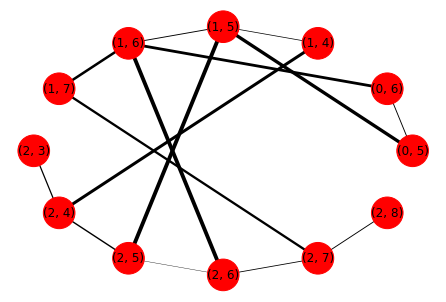

Cut size: 0


In [11]:
# Test with the empty S and all nodes placed in T.
output_cut([])

To get cuts using the QAOA we will first need to extract the best control parameters found during the sweep:

In [12]:
best_exp_index = np.unravel_index(np.argmax(exp_values), exp_values.shape)
best_parameters = par_values[best_exp_index]
print(f'Best control parameters: {best_parameters}')

Best control parameters: [3.14159265 6.28318531]


Each bitstring can be seen as a candidate cut in the graph. The qubits that measured 0 correspond to that qubit being in one cut partition and a qubit that measured to 1 corresponds to that qubit being in the other cut partition. Now that we've found good parameters for the `qaoa_circuit`, we can just sample some bistrings, iterate over them and pick the one that gives the best cut:

In [13]:
# Number of candidate cuts to sample.
num_cuts = 100
candidate_cuts = sim.sample(
    qaoa_circuit,
    params={alpha: best_parameters[0], beta: best_parameters[1]},
    repetitions=num_cuts
)

# Variables to store best cut partitions and cut size.
best_qaoa_S_partition = set()
best_qaoa_T_partition = set()
best_qaoa_cut_size = -np.inf

# Analyze each candidate cut.
for i in range(num_cuts):
  candidate = candidate_cuts.iloc[i]
  one_qubits = set(candidate[candidate==1].index)
  S_partition = set()
  T_partition = set()
  for node in working_graph:
    if str(node) in one_qubits:
      # If a one was measured add node to S partition.
      S_partition.add(node)
    else:
      # Otherwise a zero was measured so add to T partition.
      T_partition.add(node)

  cut_size = nx.cut_size(
      working_graph, S_partition, T_partition, weight='weight')
  
  # If you found a better cut update best_qaoa_cut variables.
  if cut_size > best_qaoa_cut_size:
    best_qaoa_cut_size = cut_size
    best_qaoa_S_partition = S_partition
    best_qaoa_T_partition = T_partition

The QAOA is known to do just a little better better than random guessing for Max-Cut on 3-regular graphs at `p=1`. You can use very similar logic to the code above, but now instead of relying on the QAOA to decied your `S_partition` and `T_partition` you can just pick then randomly:

In [14]:
import random

best_random_S_partition = set()
best_random_T_partition = set()
best_random_cut_size = -9999

# Randomly build candidate sets.
for i in range(num_cuts):
  S_partition = set()
  T_partition = set()
  for node in working_graph:
    if random.random() > 0.5:
      # If we flip heads add to S.
      S_partition.add(node)
    else:
      # Otherwise add to T.
      T_partition.add(node)

  cut_size = nx.cut_size(
      working_graph, S_partition, T_partition, weight='weight')
  
  # If you found a better cut update best_random_cut variables.
  if cut_size > best_random_cut_size:
    best_random_cut_size = cut_size
    best_random_S_partition = S_partition
    best_random_T_partition = T_partition

-----QAOA-----


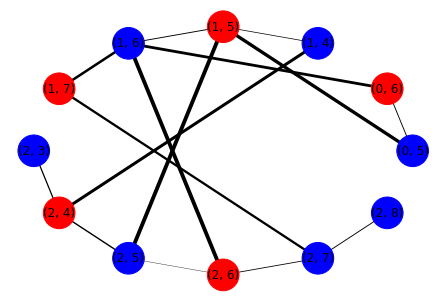

Cut size: 28.07


-----RANDOM-----


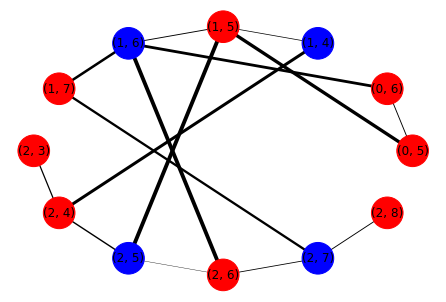

Cut size: 23.500000000000004


In [15]:
print('-----QAOA-----')
output_cut(best_qaoa_S_partition)

print('\n\n-----RANDOM-----')
output_cut(best_random_S_partition)

For this problem instance, one should see that $p = 1$ QAOA performs better, on average, than randomly guessing.